# 영화 추천 시스템 모델링

이 노트북에서는 data_scraping 폴더에서 수집한 영화 데이터를 활용하여 영화 추천 시스템을 구축합니다.

## 목차
1. 데이터 로딩 및 전처리
2. 탐색적 데이터 분석 (EDA)
3. 협업 필터링 (Collaborative Filtering)
4. 컨텐츠 기반 필터링 (Content-Based Filtering)
5. 하이브리드 추천 시스템
6. 모델 평가


In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse.linalg import svds
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료!")


라이브러리 로드 완료!


## 1. 데이터 로딩 및 전처리

In [2]:
# 데이터 파일 경로
DATA_PATH = '../data_scraping/data/'

# 1. 영화 정보 데이터 로드
print("영화 정보 데이터 로딩 중...")
movie_info = []
with open(DATA_PATH + 'movie_info_watcha.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('/')
        if len(parts) >= 11:
            movie_info.append({
                'movie_id': parts[0],
                'title': parts[1],
                'year': parts[2],
                'genre': parts[3],
                'country': parts[4],
                'runtime': parts[5],
                'rating': parts[6],
                'cast': parts[7],
                'plot': parts[8],
                'avg_score': parts[9],
                'popularity': parts[10],
                'review_count': parts[11] if len(parts) > 11 else None
            })

df_movies = pd.DataFrame(movie_info)
print(f"영화 정보 데이터: {len(df_movies)}개")
df_movies.head()


영화 정보 데이터 로딩 중...
영화 정보 데이터: 13782개


,movie_id,title,year,genre,country,runtime,rating,cast,plot,avg_score,popularity,review_count
0,m45nEnd,사마리아,2004,드라마,한국,1시간 35분,청불,"[('김기덕', '감독'), ('이얼', '주연 | 영기'), ('곽지민', '주연...","""인도에 바수밀다 라는 창녀가 있었어. 그런데 그 창녀랑 잠만 자고 나면 남자들이 ...",2.8,3.4,500+
1,mWLjGNd,택시 드라이버,1976,드라마 스릴러,미국,1시간 53분,청불,"[('마틴 스콜세지', '감독'), ('로버트 드 니로', '주연 | 트래비스'),...",트래비스(로버트 드 니로)는 베트남전에서 귀환한 후 불면증에 시달리며 사회에 적응하...,4.0,10.8,4000+
2,mOk6BPQ,파울볼,2014,다큐멘터리,한국,1시간 27분,전체,"[('조정래', '감독'), ('김보경', '감독'), ('조진웅', '나레이션')...","한,미,일 3개국 프로야구 선수 출신 최향남, 국내 프로야구 신인왕 출신 김수경 등...",3.3,7355.0,500+
3,mdBzPGd,청설,2009,드라마 로맨스,대만,1시간 49분,전체,"[('청펀펀', '감독'), ('펑위옌', '주연 | 티엔커'), ('진의함', '...",손으로 말하는 ‘양양’과 그녀에게 첫눈에 반한 ‘티엔커’. 마음이 듣고 가슴으로 느...,3.8,16.5,2000+
4,mObJJRO,하녀 라본느,None,None,None,1시간 22분,청불,"[('살바토르 샘페리', '감독'), ('플로랑스 구에린', '주연'), ('트린 ...",None,2.5,36.0,10+


In [3]:
# 2. 사용자 평점 데이터 로드
print("\n사용자 평점 데이터 로딩 중...")
ratings = []
with open(DATA_PATH + 'custom_movie_rating.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('/')
        if len(parts) >= 4:
            try:
                ratings.append({
                    'user_id': parts[0],
                    'movie_id': parts[1],
                    'movie_title': parts[2],
                    'rating': float(parts[3])
                })
            except ValueError:
                continue

df_ratings = pd.DataFrame(ratings)
print(f"평점 데이터: {len(df_ratings)}개")
print(f"고유 사용자 수: {df_ratings['user_id'].nunique()}")
print(f"고유 영화 수: {df_ratings['movie_id'].nunique()}")
df_ratings.head()



사용자 평점 데이터 로딩 중...
평점 데이터: 85891개
고유 사용자 수: 139
고유 영화 수: 13784


,user_id,movie_id,movie_title,rating
0,ZBm5R0Mj7qd46,m5XKVDL,양자물리학,3.0
1,ZBm5R0Mj7qd46,m5Nn2GE,영화로운 작음,3.5
2,ZBm5R0Mj7qd46,mWvq0vZ,내 방,2.5
3,ZBm5R0Mj7qd46,mdKpyBk,성적표의 김민영,3.0
4,ZBm5R0Mj7qd46,mOopbwm,킹덤4: 대장군의 귀환,3.0


In [4]:
# 3. 영화 댓글/리뷰 데이터 로드
print("\n영화 리뷰 데이터 로딩 중...")
reviews = []
with open(DATA_PATH + 'movie_comments.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('/')
        if len(parts) >= 4:
            try:
                reviews.append({
                    'movie_id': parts[0],
                    'review_id': parts[1],
                    'review_text': parts[2],
                    'rating': float(parts[3]) if parts[3] != 'None' else None,
                    'length': int(parts[4]) if len(parts) > 4 else len(parts[2])
                })
            except (ValueError, IndexError):
                continue

df_reviews = pd.DataFrame(reviews)
print(f"리뷰 데이터: {len(df_reviews)}개")
print(f"리뷰가 있는 영화 수: {df_reviews['movie_id'].nunique()}")
df_reviews.head()



영화 리뷰 데이터 로딩 중...
리뷰 데이터: 56140개
리뷰가 있는 영화 수: 171


,movie_id,review_id,review_text,rating,length
0,m5XKVDL,yKZx3nJg254dJ,"""양자물리학""이라는 제목만 빼고 전반적으로 다 괜찮은 영화. . . #현시점대한민국...",3.0,152
1,m5XKVDL,nkPvrb8wrvgar,"안녕하세요, 물리학과입니다. 이런게 물리라면 저는 문과입니다. Never quite...",2.0,141
2,m5XKVDL,yKZx37WjDx4dJ,양자물리학을 억지로 개연성도 없이 영화에 삽입시키고있다 검사님 연기 리스펙,2.5,128
3,m5XKVDL,6ewxakKkyvQ1m,검사 연기가 후덜덜 특히 곽철용과의 씬들이 재밌는데 거의 검사실 몰카 보는 수준이다...,4.0,97
4,m5XKVDL,Qgy51rmX7xDjk,우아는커녕 추잡스럽게.,2.0,91


In [5]:
# 데이터 전처리
print("\n데이터 전처리 중...")

# 영화 정보 데이터 전처리
df_movies['avg_score'] = pd.to_numeric(df_movies['avg_score'], errors='coerce')
df_movies['popularity'] = pd.to_numeric(df_movies['popularity'], errors='coerce')
df_movies['year'] = pd.to_numeric(df_movies['year'], errors='coerce')

# 결측치 제거
df_movies = df_movies.dropna(subset=['avg_score'])
df_ratings = df_ratings.dropna(subset=['rating'])

# 평점 범위 확인 (0~5점)
df_ratings = df_ratings[(df_ratings['rating'] >= 0) & (df_ratings['rating'] <= 5)]

print(f"\n전처리 후 영화 수: {len(df_movies)}")
print(f"전처리 후 평점 수: {len(df_ratings)}")
print(f"전처리 후 리뷰 수: {len(df_reviews)}")



데이터 전처리 중...

전처리 후 영화 수: 13775
전처리 후 평점 수: 85891
전처리 후 리뷰 수: 56140


## 2. 탐색적 데이터 분석 (EDA)

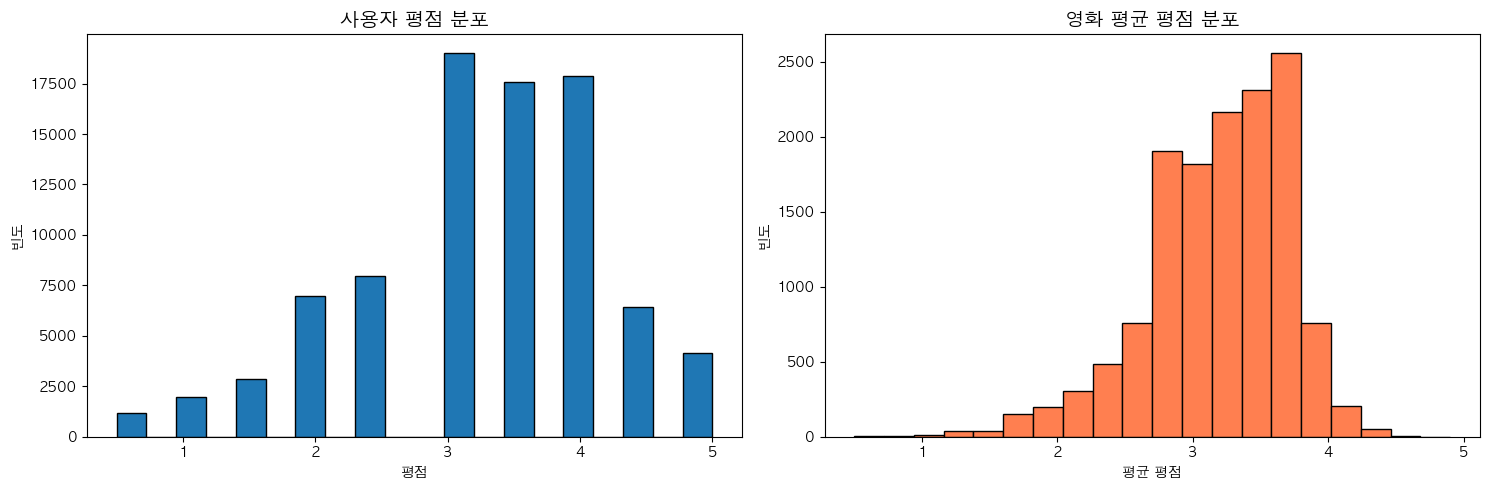

평균 사용자 평점: 3.26
평균 영화 평점: 3.19


In [6]:
# 평점 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 사용자 평점 분포
axes[0].hist(df_ratings['rating'], bins=20, edgecolor='black')
axes[0].set_title('사용자 평점 분포', fontsize=14)
axes[0].set_xlabel('평점')
axes[0].set_ylabel('빈도')

# 영화 평균 평점 분포
axes[1].hist(df_movies['avg_score'], bins=20, edgecolor='black', color='coral')
axes[1].set_title('영화 평균 평점 분포', fontsize=14)
axes[1].set_xlabel('평균 평점')
axes[1].set_ylabel('빈도')

plt.tight_layout()
plt.show()

print(f"평균 사용자 평점: {df_ratings['rating'].mean():.2f}")
print(f"평균 영화 평점: {df_movies['avg_score'].mean():.2f}")


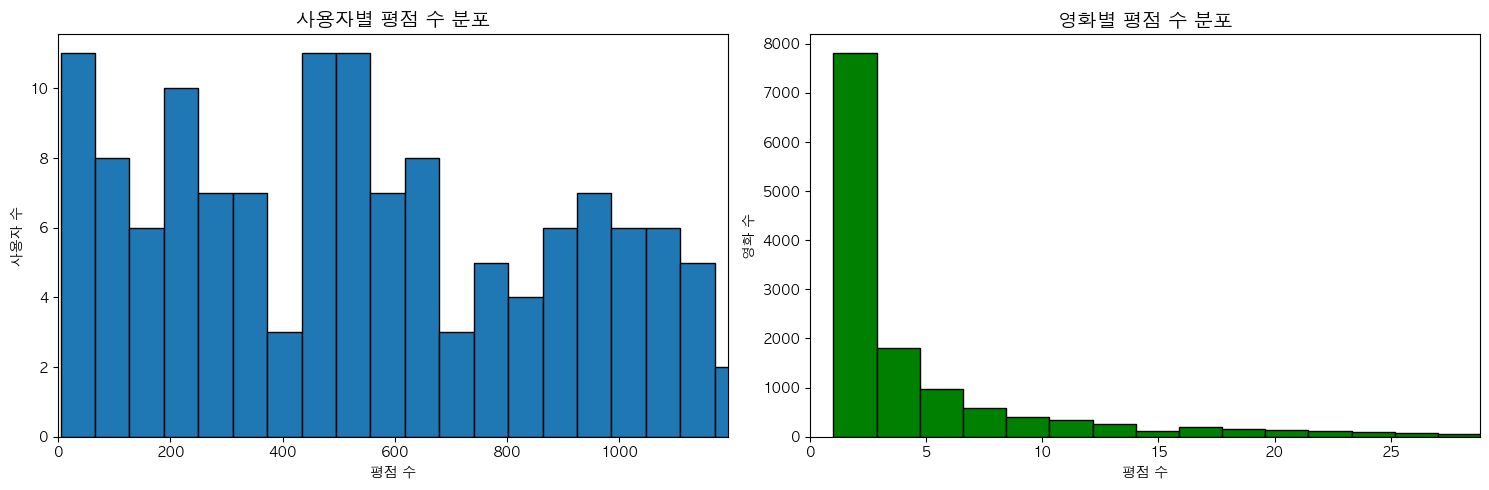

사용자당 평균 평점 수: 617.92
영화당 평균 평점 수: 6.23


In [7]:
# 사용자별 평점 수 분석
user_rating_counts = df_ratings.groupby('user_id').size()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 사용자별 평점 수 분포
axes[0].hist(user_rating_counts, bins=50, edgecolor='black')
axes[0].set_title('사용자별 평점 수 분포', fontsize=14)
axes[0].set_xlabel('평점 수')
axes[0].set_ylabel('사용자 수')
axes[0].set_xlim(0, user_rating_counts.quantile(0.95))

# 영화별 평점 수 분포
movie_rating_counts = df_ratings.groupby('movie_id').size()
axes[1].hist(movie_rating_counts, bins=50, edgecolor='black', color='green')
axes[1].set_title('영화별 평점 수 분포', fontsize=14)
axes[1].set_xlabel('평점 수')
axes[1].set_ylabel('영화 수')
axes[1].set_xlim(0, movie_rating_counts.quantile(0.95))

plt.tight_layout()
plt.show()

print(f"사용자당 평균 평점 수: {user_rating_counts.mean():.2f}")
print(f"영화당 평균 평점 수: {movie_rating_counts.mean():.2f}")


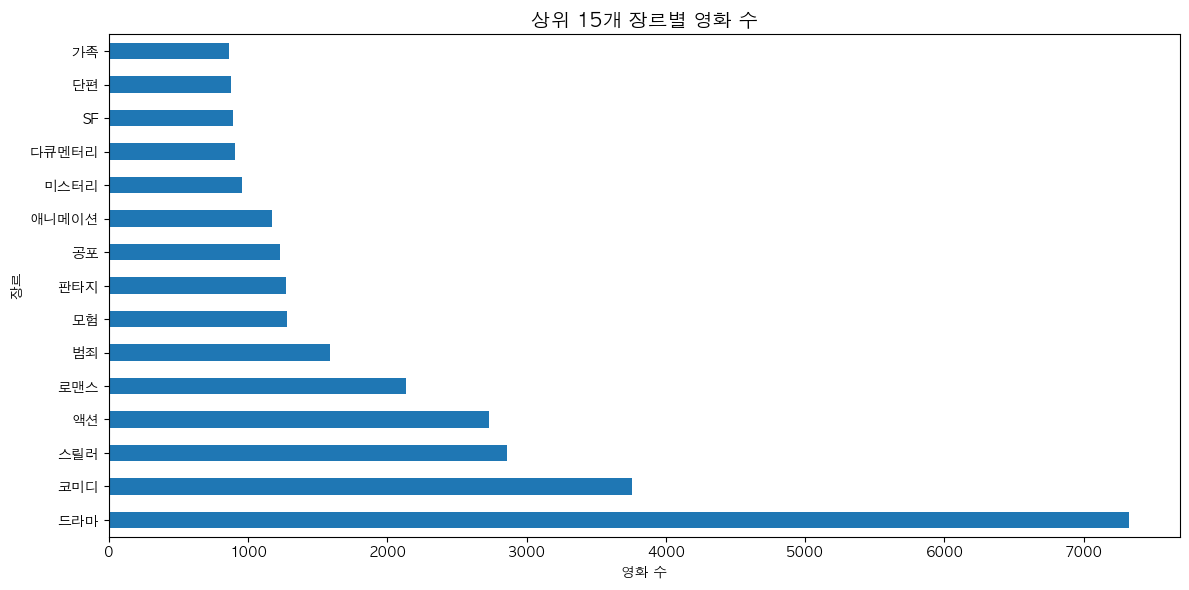

In [8]:
# 장르별 분석
all_genres = []
for genres in df_movies['genre'].dropna():
    if genres != 'None':
        all_genres.extend(genres.split())

genre_counts = pd.Series(all_genres).value_counts().head(15)

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='barh')
plt.title('상위 15개 장르별 영화 수', fontsize=14)
plt.xlabel('영화 수')
plt.ylabel('장르')
plt.tight_layout()
plt.show()


## 3. 협업 필터링 (Collaborative Filtering)

사용자-영화 평점 행렬을 기반으로 한 협업 필터링 추천 시스템을 구축합니다.


In [9]:
# User-Item 평점 행렬 생성
print("User-Item 평점 행렬 생성 중...")

# 최소 평점 수 필터링 (노이즈 제거)
min_user_ratings = 5  # 최소 5개 이상 평가한 사용자
min_movie_ratings = 5  # 최소 5개 이상 평가받은 영화

user_counts = df_ratings.groupby('user_id').size()
movie_counts = df_ratings.groupby('movie_id').size()

active_users = user_counts[user_counts >= min_user_ratings].index
popular_movies = movie_counts[movie_counts >= min_movie_ratings].index

df_ratings_filtered = df_ratings[
    (df_ratings['user_id'].isin(active_users)) & 
    (df_ratings['movie_id'].isin(popular_movies))
]

print(f"필터링 후 사용자 수: {df_ratings_filtered['user_id'].nunique()}")
print(f"필터링 후 영화 수: {df_ratings_filtered['movie_id'].nunique()}")
print(f"필터링 후 평점 수: {len(df_ratings_filtered)}")

# Pivot table 생성
user_movie_matrix = df_ratings_filtered.pivot_table(
    index='user_id',
    columns='movie_id',
    values='rating'
)

print(f"\n평점 행렬 크기: {user_movie_matrix.shape}")
sparsity = (user_movie_matrix.isna().sum().sum() / (user_movie_matrix.shape[0] * user_movie_matrix.shape[1]) * 100)
print(f"Sparsity: {sparsity:.2f}%")


User-Item 평점 행렬 생성 중...
필터링 후 사용자 수: 138
필터링 후 영화 수: 4172
필터링 후 평점 수: 69969

평점 행렬 크기: (138, 4172)
Sparsity: 87.85%


In [10]:
# Train-Test Split
train_data, test_data = train_test_split(df_ratings_filtered, test_size=0.2, random_state=42)

print(f"Train 데이터: {len(train_data)}개")
print(f"Test 데이터: {len(test_data)}개")


Train 데이터: 55975개
Test 데이터: 13994개


In [11]:
# Matrix Factorization을 이용한 협업 필터링
# SVD (Singular Value Decomposition) 활용

def matrix_factorization_predict(train_data, test_data, n_factors=50):
    """
    SVD를 이용한 Matrix Factorization 기반 추천
    """
    # Train matrix 생성
    train_matrix = train_data.pivot_table(
        index='user_id',
        columns='movie_id',
        values='rating'
    ).fillna(0)
    
    # 평균 평점 계산 (centering)
    user_ratings_mean = np.mean(train_matrix.values, axis=1)
    matrix_centered = train_matrix.values - user_ratings_mean.reshape(-1, 1)
    
    # SVD 수행
    print(f"SVD 수행 중 (n_factors={n_factors})...")
    U, sigma, Vt = svds(matrix_centered, k=n_factors)
    sigma = np.diag(sigma)
    
    # 예측 행렬 생성
    predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    predicted_df = pd.DataFrame(
        predicted_ratings,
        index=train_matrix.index,
        columns=train_matrix.columns
    )
    
    return predicted_df, train_matrix.index, train_matrix.columns

# 예측 수행
predicted_ratings, user_ids, movie_ids = matrix_factorization_predict(train_data, test_data, n_factors=50)
print("\nMatrix Factorization 완료!")


SVD 수행 중 (n_factors=50)...

Matrix Factorization 완료!


In [12]:
# 모델 평가
def evaluate_model(predicted_df, test_data, user_ids, movie_ids):
    """
    RMSE와 MAE를 이용한 모델 평가
    """
    predictions = []
    actuals = []
    
    for _, row in test_data.iterrows():
        user_id = row['user_id']
        movie_id = row['movie_id']
        actual_rating = row['rating']
        
        if user_id in user_ids and movie_id in movie_ids:
            predicted_rating = predicted_df.loc[user_id, movie_id]
            predictions.append(predicted_rating)
            actuals.append(actual_rating)
    
    if len(predictions) > 0:
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        return rmse, mae, len(predictions)
    else:
        return None, None, 0

rmse, mae, n_predictions = evaluate_model(predicted_ratings, test_data, user_ids, movie_ids)

if rmse is not None:
    print(f"\n=== 협업 필터링 모델 평가 ===")
    print(f"평가된 예측 수: {n_predictions}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
else:
    print("평가 데이터가 충분하지 않습니다.")



=== 협업 필터링 모델 평가 ===
평가된 예측 수: 13989
RMSE: 3.1313
MAE: 2.9432


In [13]:
# 특정 사용자에게 영화 추천
def recommend_movies_for_user(user_id, predicted_df, df_ratings, df_movies, n_recommendations=10):
    """
    특정 사용자에게 영화 추천
    """
    if user_id not in predicted_df.index:
        print(f"사용자 {user_id}를 찾을 수 없습니다.")
        return None
    
    # 사용자가 이미 평가한 영화 제외
    user_ratings = df_ratings[df_ratings['user_id'] == user_id]['movie_id'].values
    
    # 예측 평점 가져오기
    user_predictions = predicted_df.loc[user_id]
    
    # 이미 본 영화 제외
    recommendations = user_predictions.drop(user_ratings, errors='ignore')
    
    # 상위 N개 추천
    top_recommendations = recommendations.sort_values(ascending=False).head(n_recommendations)
    
    # 영화 정보 병합
    result = []
    for movie_id, predicted_rating in top_recommendations.items():
        movie_info = df_movies[df_movies['movie_id'] == movie_id]
        if not movie_info.empty:
            result.append({
                'movie_id': movie_id,
                'title': movie_info.iloc[0]['title'],
                'genre': movie_info.iloc[0]['genre'],
                'predicted_rating': predicted_rating,
                'avg_score': movie_info.iloc[0]['avg_score']
            })
    
    return pd.DataFrame(result)

# 예시: 첫 번째 사용자에게 추천
sample_user = user_ids[0]
recommendations = recommend_movies_for_user(sample_user, predicted_ratings, df_ratings_filtered, df_movies, n_recommendations=10)

if recommendations is not None:
    print(f"\n사용자 {sample_user}에게 추천하는 영화:")
    print(recommendations[['title', 'genre', 'predicted_rating', 'avg_score']])



사용자 17ovVQ8PKlqzy에게 추천하는 영화:
                   title                   genre  predicted_rating  avg_score
0                     괴물                드라마 미스터리          1.660739        4.3
1                     소울  애니메이션 모험 가족 SF 판타지 코미디          1.568952        4.0
2              콘크리트 유토피아            드라마 스릴러 미스터리          1.341813        3.4
3             더 퍼스트 슬램덩크               애니메이션 스포츠          1.279600        4.1
4                슬픔의 삼각형                 코미디 드라마          1.272215        3.7
5                      놉          공포 미스터리 SF 스릴러          1.225493        3.5
6  가디언즈 오브 갤럭시: Volume 3            액션 모험 코미디 SF          1.218486        4.1
7                     파묘                미스터리 스릴러          1.171579        3.5
8                     큐어                스릴러 미스터리          1.110751        4.0
9             존 오브 인터레스트               드라마 역사 전쟁          1.108328        4.0


## 4. 컨텐츠 기반 필터링 (Content-Based Filtering)

영화의 장르, 줄거리 등을 활용한 컨텐츠 기반 추천 시스템을 구축합니다.

In [14]:
# 컨텐츠 기반 필터링: TF-IDF를 이용한 유사도 계산
print("컨텐츠 기반 필터링 준비 중...")

# 장르와 줄거리를 결합한 특성 생성
df_movies['content'] = df_movies['genre'].fillna('') + ' ' + df_movies['plot'].fillna('')

# TF-IDF 벡터화
tfidf = TfidfVectorizer(max_features=5000, stop_words=None)
tfidf_matrix = tfidf.fit_transform(df_movies['content'])

print(f"TF-IDF 행렬 크기: {tfidf_matrix.shape}")

# 코사인 유사도 계산
print("코사인 유사도 계산 중...")
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("코사인 유사도 계산 완료!")


컨텐츠 기반 필터링 준비 중...
TF-IDF 행렬 크기: (13775, 5000)
코사인 유사도 계산 중...
코사인 유사도 계산 완료!


In [15]:
# 컨텐츠 기반 추천 함수
def content_based_recommendations(movie_title, df_movies, cosine_sim, n_recommendations=10):
    """
    특정 영화와 유사한 영화 추천
    """
    # 영화 제목으로 인덱스 찾기
    movie_indices = df_movies[df_movies['title'].str.contains(movie_title, case=False, na=False)].index
    
    if len(movie_indices) == 0:
        print(f"'{movie_title}'를 찾을 수 없습니다.")
        return None
    
    idx = movie_indices[0]
    
    # 유사도 점수 가져오기
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # 유사도 기준 정렬 (자기 자신 제외)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n_recommendations+1]
    
    # 영화 인덱스 추출
    movie_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]
    
    # 추천 영화 정보 반환
    recommendations = df_movies.iloc[movie_indices][['title', 'genre', 'avg_score', 'year']].copy()
    recommendations['similarity'] = similarity_scores
    
    return recommendations

# 예시: 첫 번째 영화와 유사한 영화 추천
sample_movie = df_movies.iloc[0]['title']
print(f"\n'{sample_movie}'와 유사한 영화 추천:")
similar_movies = content_based_recommendations(sample_movie, df_movies, cosine_sim, n_recommendations=10)

if similar_movies is not None:
    print(similar_movies)



'사마리아'와 유사한 영화 추천:
                    title          genre  avg_score    year  similarity
3065               악은 악으로             공포        1.8  1972.0    0.293208
821                    혐오     드라마 공포 스릴러        3.7  1965.0    0.187667
8230                암고양이들            드라마        2.6  2016.0    0.184134
5062          당신은 몇번째인가요?        코미디 로맨스        3.3  2011.0    0.177572
6067              언더 더 스킨         SF 드라마        3.2  2013.0    0.167550
6726                 헬레이저         공포 스릴러        3.3  1987.0    0.166825
11193                천녀유혼  액션 판타지 공포 로맨스        3.8  1987.0    0.161403
11849  스토리 오브 O - 르네의 사생활            드라마        2.5  1975.0    0.154642
6628      에로스: 왕가위 감독 특별판            드라마        3.7  2004.0    0.152846
13676              별들의 고향        드라마 로맨스        3.1  1974.0    0.151302


## 5. 하이브리드 추천 시스템

협업 필터링과 컨텐츠 기반 필터링을 결합한 하이브리드 추천 시스템을 구축합니다.


In [16]:
# 하이브리드 추천 함수
def hybrid_recommendations(user_id, predicted_df, df_ratings, df_movies, cosine_sim, 
                          n_recommendations=10, cf_weight=0.6, cb_weight=0.4):
    """
    협업 필터링과 컨텐츠 기반 필터링을 결합한 하이브리드 추천
    
    Parameters:
    - cf_weight: 협업 필터링 가중치 (0~1)
    - cb_weight: 컨텐츠 기반 필터링 가중치 (0~1)
    """
    if user_id not in predicted_df.index:
        print(f"사용자 {user_id}를 찾을 수 없습니다.")
        return None
    
    # 1. 협업 필터링 점수
    user_ratings = df_ratings[df_ratings['user_id'] == user_id]['movie_id'].values
    cf_scores = predicted_df.loc[user_id].drop(user_ratings, errors='ignore')
    
    # 2. 컨텐츠 기반 점수 (사용자가 본 영화와 유사한 영화)
    cb_scores = pd.Series(0.0, index=df_movies['movie_id'])
    
    # 사용자가 높게 평가한 영화들과 유사한 영화 찾기
    user_high_rated = df_ratings[(df_ratings['user_id'] == user_id) & (df_ratings['rating'] >= 4.0)]
    
    for _, row in user_high_rated.iterrows():
        movie_id = row['movie_id']
        movie_idx = df_movies[df_movies['movie_id'] == movie_id].index
        
        if len(movie_idx) > 0:
            idx = movie_idx[0]
            sim_scores = cosine_sim[idx]
            
            for i, score in enumerate(sim_scores):
                target_movie_id = df_movies.iloc[i]['movie_id']
                if target_movie_id not in user_ratings:
                    cb_scores[target_movie_id] += score
    
    # 정규화
    if cb_scores.max() > 0:
        cb_scores = cb_scores / cb_scores.max() * 5  # 0~5 스케일로 변환
    
    # 3. 하이브리드 점수 계산
    common_movies = cf_scores.index.intersection(cb_scores.index)
    hybrid_scores = cf_weight * cf_scores[common_movies] + cb_weight * cb_scores[common_movies]
    
    # 상위 N개 추천
    top_recommendations = hybrid_scores.sort_values(ascending=False).head(n_recommendations)
    
    # 영화 정보 병합
    result = []
    for movie_id, hybrid_score in top_recommendations.items():
        movie_info = df_movies[df_movies['movie_id'] == movie_id]
        if not movie_info.empty:
            result.append({
                'movie_id': movie_id,
                'title': movie_info.iloc[0]['title'],
                'genre': movie_info.iloc[0]['genre'],
                'hybrid_score': hybrid_score,
                'cf_score': cf_scores.get(movie_id, 0),
                'cb_score': cb_scores.get(movie_id, 0),
                'avg_score': movie_info.iloc[0]['avg_score']
            })
    
    return pd.DataFrame(result)

# 하이브리드 추천 예시
sample_user = user_ids[0]
hybrid_recs = hybrid_recommendations(sample_user, predicted_ratings, df_ratings_filtered, 
                                    df_movies, cosine_sim, n_recommendations=10)

if hybrid_recs is not None:
    print(f"\n=== 하이브리드 추천 결과 (사용자: {sample_user}) ===")
    print(hybrid_recs[['title', 'genre', 'hybrid_score', 'cf_score', 'cb_score', 'avg_score']])



=== 하이브리드 추천 결과 (사용자: 17ovVQ8PKlqzy) ===
                 title                    genre  hybrid_score  cf_score  \
0                 얼라이드        액션 드라마 로맨스 스릴러 전쟁      1.999991  0.255704   
1     바람의 검심 : 교토 대화재편                   액션 시대극      1.936978  0.189943   
2     바람의 검심 : 전설의 최후편                       액션      1.778743 -0.045852   
3          배드 맘스 크리스마스               드라마 모험 코미디      1.554019  0.306594   
4               대부 일대기                   드라마 범죄      1.372385  0.008935   
5          라푼젤 그 후 이야기          액션 애니메이션 코미디 가족      1.367217  0.070576   
6                   괴물                 드라마 미스터리      1.348597  1.660739   
7  더 스트레인지 띵 어바웃 더 존슨즈        단편 코미디 드라마 공포 스릴러      1.293699  0.194712   
8                  오믈렛          애니메이션 코미디 가족 단편      1.190581  0.025394   
9                   위시  애니메이션 모험 코미디 가족 판타지 뮤지컬      1.183980  0.437471   

   cb_score  avg_score  
0  4.616421        3.6  
1  4.557531        3.6  
2  4.515636        3.7  
3  3.425158        3.2  
4  3.41

## 6. 모델 저장 및 활용


In [ ]:
# 추천 시스템 결과 저장
import pickle

# 모델 저장
model_data = {
    'predicted_ratings': predicted_ratings,
    'cosine_sim': cosine_sim,
    'df_movies': df_movies,
    'df_ratings': df_ratings_filtered,
    'user_ids': user_ids,
    'movie_ids': movie_ids
}

with open('movie_recommendation_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("모델이 'movie_recommendation_model.pkl'에 저장되었습니다.")


In [ ]:
# 추천 시스템 요약
print("\n" + "="*60)
print("영화 추천 시스템 모델링 완료!")
print("="*60)
print(f"\n총 영화 수: {len(df_movies)}")
print(f"총 사용자 수: {df_ratings_filtered['user_id'].nunique()}")
print(f"총 평점 수: {len(df_ratings_filtered)}")
if rmse:
    print(f"\n협업 필터링 RMSE: {rmse:.4f}")
    print(f"협업 필터링 MAE: {mae:.4f}")
print("\n3가지 추천 방식:")
print("  1. 협업 필터링 (Collaborative Filtering)")
print("  2. 컨텐츠 기반 필터링 (Content-Based Filtering)")
print("  3. 하이브리드 추천 (Hybrid Recommendation)")
